In [190]:
import requests
import json
import pandas as pd
import time
import re
import urllib
import matplotlib
import numpy as np
pd.set_option('display.max_colwidth', None)

In [191]:
import boto3
from io import StringIO

In [192]:
try:
    df = pd.read_csv("./data/astro/swaps.csv")
    df.timestamp = pd.to_datetime(df.timestamp, format='mixed')
except Exception as e:
    print(f"No file yet {e}")
    df = None

In [193]:
assets = {
    'ibc/B3504E092456BA618CC28AC671A71FB08C6CA0FD0BE7C8A5B5A3E2DD933CC9E4':'axlUSDC',
    'terra1nsuqsk6kh58ulczatwev87ttq2z6r3pusulg9r24mfj2fvtzd4uq3exn26':'ASTRO'
}

In [194]:
df = df.drop_duplicates(ignore_index=True)
df.returnAsset = df.returnAsset.replace(assets)
df.offerAsset = df.offerAsset.replace(assets)

In [195]:
df['date'] = df.timestamp.apply(lambda x: x.strftime("%Y-%m-%d"))

In [196]:
_sell = df[df.offerAsset=='ASTRO']
_buy = df[df.returnAsset=='ASTRO']
_sell['astro_amount'] =  - _sell.offerAmount
_buy['astro_amount'] =  _buy.returnAmount
df = pd.concat([_sell, _buy])

/tmp/ipykernel_48/2204474832.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _sell['astro_amount'] =  - _sell.offerAmount
/tmp/ipykernel_48/2204474832.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _buy['astro_amount'] =  _buy.returnAmount


In [197]:
tokens = [
"xASTRO",
"SAYVE",
"ORNE",
"ASTRO",
"ampLUNA",
"ROAR",
"boneLuna"
]

In [198]:
import requests
import json

def get_balances(address):
    url = "https://starscream-terra-mainnet.chainscope.dev/"
    headers = {
        "Content-Type": "application/json"
    }
    
    body = {
        "query": """
        query Query($address: String!, $tokenContracts: [String!]!) {
            tokenBalances(address: $address, tokenContracts: $tokenContracts)
        }
        """,
        "variables": {
            "address": f"{address}",
            "tokenContracts": [
                "terra1x62mjnme4y0rdnag3r8rfgjuutsqlkkyuh4ndgex0wl3wue25uksau39q8",
                "terra1xp9hrhthzddnl7j5du83gqqr4wmdjm5t0guzg9jp6jwrtpukwfjsjgy4f3",
                "terra19p20mfnvwh9yvyr7aus3a6z6g6uk28fv4jhx9kmnc2m7krg27q2qkfenjw",
                "terra1nsuqsk6kh58ulczatwev87ttq2z6r3pusulg9r24mfj2fvtzd4uq3exn26",
                "terra1ecgazyd0waaj3g7l9cmy5gulhxkps2gmxu9ghducvuypjq68mq2s5lvsct",
                "terra1lxx40s29qvkrcj8fsa3yzyehy7w50umdvvnls2r830rys6lu2zns63eelv",
                "terra17aj4ty4sz4yhgm08na8drc0v03v2jwr3waxcqrwhajj729zhl7zqnpc0ml"
            ]
        },
        "operationName": "Query"
    }
    
    response = requests.post(url, headers=headers, data=json.dumps(body))
    
    if response.status_code == 200:
        result = response.json()
        return result
    else:
        print("Request failed with status code:", response.status_code)

In [199]:
addresses = set(df.traderAddress.tolist())

In [200]:
balances = []
for address in addresses:
    try:
        balance_dict = {k: int(v)/1000000 for k, v in zip(tokens, get_balances(address)['data']['tokenBalances'])}
        balance_dict['traderAddress']= address
        balances.append(balance_dict)
    except:
        print(f"Error processing: {address}")

In [201]:
balances_df = pd.DataFrame(balances)
balances_df['total_astro_holdings'] = balances_df['ASTRO'] + balances_df['xASTRO']

In [202]:
df_ = pd.DataFrame(balances_df).merge(df, on='traderAddress')

In [235]:
percentile = 0.90

In [236]:
balances_df.total_astro_holdings.quantile(percentile)

38818.38047090001

In [237]:
whales = balances_df[balances_df.total_astro_holdings > balances_df.total_astro_holdings.quantile(percentile)]
whales.head()

,xASTRO,SAYVE,ORNE,ASTRO,ampLUNA,ROAR,boneLuna,traderAddress,total_astro_holdings
13,154098.789836,0.0,0.0,0.000000,1023.671885,288895.713689,4.280547,terra1h0w67ysrzstmrwyg4uckdzl88phf0r7qewrtj2,154098.789836
24,117346.145678,0.0,0.0,0.000000,0.000000,0.000000,0.485037,terra1zsqu60y738u0jgk36sdrptq44ejke6a7e392sd,117346.145678
32,77465.962741,0.0,0.0,0.000000,0.000000,41332.602466,0.000000,terra1np8da70jw504xg3tau6rfupfhfttfprlkk2ky9,77465.962741
33,50643.199700,0.0,0.0,0.000000,0.000000,0.000000,0.000000,terra136hclskp4yr4erzqcd6zf8fpnnrux9qz999he7,50643.199700
42,70039.102612,0.0,0.0,2772.871529,0.000000,0.000000,0.000000,terra1ewgc27kdac0g2yqtrqgl7mp6x28vd285swah2v,72811.974141


In [238]:
len(whales)

110

In [239]:
daily_delta = df[['traderAddress','date','astro_amount']].groupby(['traderAddress','date']).sum().reset_index()

In [240]:
daily_delta[["traderAddress","astro_amount"]].groupby(['traderAddress']).sum().reset_index().sort_values(by='astro_amount')

,traderAddress,astro_amount
117,terra147vzdxzn5tq4fm7z6f5q8x46xfha7e34w4sy9j,-1.194034e+06
469,terra1evtkrqahmavh4t5x6squzpwfcr4nl5ssj67edz,-1.089544e+06
752,terra1pgvewpk8kd30f2zm85sn69k9cgkp3j8szq00j7,-7.853898e+05
97,terra13vr7ewxzvaz6nj299qqt0d6w0qwqjwhu53xnrh,-7.561296e+05
51,terra12nz7cd6zyn95jhz7v923cf7sg49vpxxmy5r79p,-7.423204e+05
...,...,...
1069,terra1zakne2kmp78fp477vaqxunj0tl27leqglkc2hw,4.764188e+05
67,terra135z8ugx4gtu2ys58rt5utk3f50lwh0qxuln7ml,6.065280e+05
409,terra1djkwwpgevx42h8j7zwtgtvy2zcd2z345n5kuhn,7.555644e+05
305,terra19k3s3gv5pfm3kh4utry9ty0hsulc2n8sv5shu8,9.332778e+05


In [241]:
whales_movements_first_july = daily_delta[daily_delta.date>='2023-07-01'].merge(whales, on='traderAddress')
whales_movements_first_july

,traderAddress,date,astro_amount,xASTRO,SAYVE,ORNE,ASTRO,ampLUNA,ROAR,boneLuna,total_astro_holdings
0,terra106nyprxug0vsx0qhxm5arnjjuqj6emnr2yn5nw,2023-07-01,32.235351,78514.806146,0.0,0.0,106926.452081,0.0,0.0,0.000000,185441.258227
1,terra106nyprxug0vsx0qhxm5arnjjuqj6emnr2yn5nw,2023-07-03,902.923391,78514.806146,0.0,0.0,106926.452081,0.0,0.0,0.000000,185441.258227
2,terra106nyprxug0vsx0qhxm5arnjjuqj6emnr2yn5nw,2023-07-06,284.907911,78514.806146,0.0,0.0,106926.452081,0.0,0.0,0.000000,185441.258227
3,terra106nyprxug0vsx0qhxm5arnjjuqj6emnr2yn5nw,2023-07-07,2587.354644,78514.806146,0.0,0.0,106926.452081,0.0,0.0,0.000000,185441.258227
4,terra106nyprxug0vsx0qhxm5arnjjuqj6emnr2yn5nw,2023-07-08,3511.545065,78514.806146,0.0,0.0,106926.452081,0.0,0.0,0.000000,185441.258227
...,...,...,...,...,...,...,...,...,...,...,...
179,terra1zsqu60y738u0jgk36sdrptq44ejke6a7e392sd,2023-07-07,5361.880295,117346.145678,0.0,0.0,0.000000,0.0,0.0,0.485037,117346.145678
180,terra1zsqu60y738u0jgk36sdrptq44ejke6a7e392sd,2023-07-13,31820.028550,117346.145678,0.0,0.0,0.000000,0.0,0.0,0.485037,117346.145678
181,terra1zysj2c4uwz3g3pvd244l708q6g7hr6qj563nss,2023-07-08,17.147098,100000.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,100000.000000
182,terra1zysj2c4uwz3g3pvd244l708q6g7hr6qj563nss,2023-07-12,84.842412,100000.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,100000.000000


<Axes: xlabel='traderAddress'>

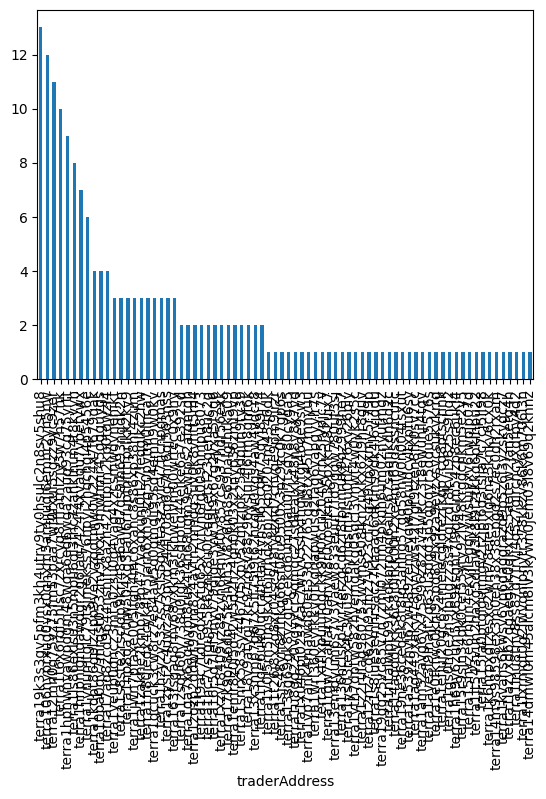

In [242]:
whales_movements_first_july.traderAddress.value_counts().plot(kind='bar')

<Axes: xlabel='traderAddress'>

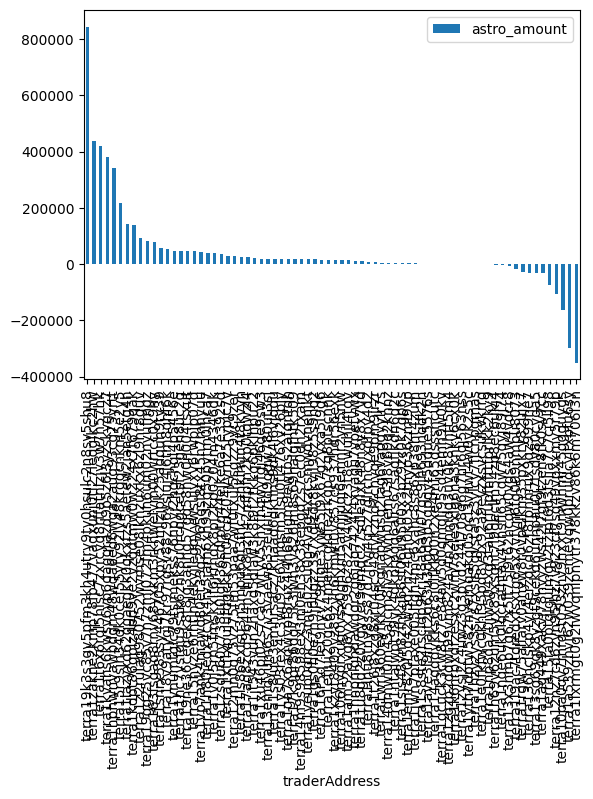

In [243]:
whales_delta_astro_fj = whales_movements_first_july[['traderAddress','astro_amount']]\
            .groupby('traderAddress')\
            .sum()\
            .sort_values(by='astro_amount', ascending=False)
whales_delta_astro_fj.plot(kind='bar')

In [247]:
index = -1

In [249]:
whales_delta_astro_fj.index[index]

'terra1lxrmgt0g2lwvqnlpnytr378kkzv86k6m706l3n'

In [250]:
whales_movements_first_july[whales_movements_first_july.traderAddress==whales_delta_astro_fj.index[index]]

,traderAddress,date,astro_amount,xASTRO,SAYVE,ORNE,ASTRO,ampLUNA,ROAR,boneLuna,total_astro_holdings
128,terra1lxrmgt0g2lwvqnlpnytr378kkzv86k6m706l3n,2023-07-02,-350000.0,2.193684e+06,0.0,0.0,0.0,0.0,0.0,0.0,2.193684e+06
